# Estimation des tailles d'échantillons réalistes

In [156]:
import codecs,math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
from datetime import datetime
from IPython.display import display

In [15]:
%matplotlib inline

#### Choix du style de plot

In [274]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("hls")
sns.set_color_codes("muted")
#sns.palplot(sns.color_palette("hls", 8))
#sns.palplot(sns.color_palette("husl", 8))

### Routines de formatages des axes matplotlib

In [17]:
def reFormatTicks(x,pos):
    text="0"
    if x!=0:
        magnitude=int(np.log10(x))
        x=round(float(x)/(10**magnitude),1)*10**magnitude
        if magnitude>=9:
            unit="G"
            value=("%.1f"%(float(x)/1e9)).strip("0").strip(".")
        elif magnitude>=6:
            unit="M"
            value=("%.1f"%(float(x)/1e6)).strip("0").strip(".")
        elif magnitude>=3:
            unit="k"
            value=("%.1f"%(float(x)/1e3)).strip("0").strip(".")
        else:
            unit=""
            value=("%.1f"%float(x)).strip("0").strip(".")
        text="%s%s"%(value,unit)
    return text

def Mois2Annees(x,pos):
    return int(x/12)


## Lecture de Lexique3
1. lecture dans un DF *Lexique3*
1. extraction des colonnes pertinentes *lex3*

In [521]:
repHDR="/Users/gilles/ownCloud/Recherche/Boye/HDR/Memoire/figs/"
nomLexiqueOrg="/Users/gilles/ownCloud/Python/phonemisation/Lexique380-UTF8.txt"
nomRepertoire="/Volumes/gilles/Transfert/Copies-iMac-GB/Python/phonemisation/"
nomLexiqueOrg=nomRepertoire+"Lexique380-UTF8.txt"
Lexique3=pd.read_csv(nomLexiqueOrg,sep="\t")

In [19]:
Lexique3.head()

,1_ortho,2_phon,3_lemme,4_cgram,5_genre,6_nombre,7_freqlemfilms2,8_freqlemlivres,9_freqfilms2,10_freqlivres,...,26_orthrenv,27_phonrenv,28_orthosyll,29_cgramortho,30_deflem,31_defobs,32_old20,33_pld20,34_morphoder,35_nbmorph
0,a,a,a,NOM,m,NaN,81.36,58.65,81.36,58.65,...,a,a,a,"NOM,AUX,VER",NaN,NaN,1.00,1.00,a,1.0
1,a,a,avoir,AUX,NaN,NaN,18559.22,12800.81,6350.91,2926.69,...,a,a,a,"NOM,AUX,VER",NaN,NaN,1.00,1.00,avoir,1.0
2,a,a,avoir,VER,NaN,NaN,13572.40,6426.49,5498.34,1669.39,...,a,a,a,"NOM,AUX,VER",93.0,16.0,1.00,1.00,avoir,1.0
3,a capella,akapEla,a capella,ADV,NaN,NaN,0.04,0.07,0.04,0.07,...,allepac a,alEpaka,a ca-pel-la,ADV,NaN,NaN,3.85,2.85,a-capella,2.0
4,a cappella,akapEla,a cappella,ADV,NaN,NaN,0.04,0.07,0.04,0.07,...,alleppac a,alEpaka,a cap-pel-la,ADV,NaN,NaN,4.60,2.85,a-cappella,2.0


In [20]:
categories=u"verbes noms adjectifs adverbes pronoms déterminants prépositions conjonctions autres".split(" ")
cgrams={
    u"verbes":["VER","AUX"],
    u"noms":["NOM"],
    u"adjectifs":["ADJ"],
    u"adverbes":["ADV"],
    u"déterminants":['ART:def', 'ADJ:ind', 'ADJ:num', 'ADJ:dem', 'ART:ind', 'ADJ:pos', 'ADJ:int'],
    u"prépositions":["PRE"],
    u"conjonctions":["CON"],
    u"pronoms":['PRO:ind', 'PRO:int', 'PRO:rel', 'PRO:dem', 'PRO:per', 'PRO:pos'],
    u"autres":['ONO', 'LIA']
}
catLex=cgrams["verbes"]+cgrams["noms"]+cgrams["adjectifs"]+cgrams["adverbes"]
catNonLex=cgrams[u"déterminants"]+cgrams[u"prépositions"]+cgrams["conjonctions"]+cgrams["pronoms"]+cgrams["autres"]


In [21]:
Lexique3.columns

Index([u'1_ortho', u'2_phon', u'3_lemme', u'4_cgram', u'5_genre', u'6_nombre',
       u'7_freqlemfilms2', u'8_freqlemlivres', u'9_freqfilms2',
       u'10_freqlivres', u'11_infover', u'12_nbhomogr', u'13_nbhomoph',
       u'14_islem', u'15_nblettres', u'16_nbphons', u'17_cvcv', u'18_p_cvcv',
       u'19_voisorth', u'20_voisphon', u'21_puorth', u'22_puphon', u'23_syll',
       u'24_nbsyll', u'25_cv-cv', u'26_orthrenv', u'27_phonrenv',
       u'28_orthosyll', u'29_cgramortho', u'30_deflem', u'31_defobs',
       u'32_old20', u'33_pld20', u'34_morphoder', u'35_nbmorph'],
      dtype='object')

In [22]:
lex3=Lexique3[["1_ortho","2_phon","3_lemme","4_cgram","5_genre","6_nombre","7_freqlemfilms2","8_freqlemlivres","9_freqfilms2","10_freqlivres","11_infover"]].copy()

In [23]:
Lexique3=None

In [24]:
lex3.loc[:,"7_freqlemfilms2"]=lex3.loc[:,"7_freqlemfilms2"].astype(float)
lex3.loc[:,"8_freqlemlivres"]=lex3.loc[:,"8_freqlemlivres"].astype(float)
lex3.loc[:,"9_freqfilms2"]=lex3.loc[:,"9_freqfilms2"].astype(float)
lex3.loc[:,"10_freqlivres"]=lex3.loc[:,"10_freqlivres"].astype(float)
lex3[["1_ortho","3_lemme","9_freqfilms2"]].head()

,1_ortho,3_lemme,9_freqfilms2
0,a,a,81.36
1,a,avoir,6350.91
2,a,avoir,5498.34
3,a capella,a capella,0.04
4,a cappella,a cappella,0.04


### Comptages des catégories

In [25]:
proportionsCgram=[]
nbFormesCgram=[]
lex3Freqfilms2Sum=lex3["9_freqfilms2"].sum()
lex3FormFilms2Sum=lex3[lex3["9_freqfilms2"]>0]["9_freqfilms2"].count()
for c in categories:
    proportion=lex3[lex3["4_cgram"].isin(cgrams[c])]["9_freqfilms2"].sum()/lex3Freqfilms2Sum
    proportionsCgram.append([c,proportion])
    nbFormes=lex3[(lex3["4_cgram"].isin(cgrams[c]))&(lex3["9_freqfilms2"]>0)]["9_freqfilms2"].count()
    nbFormesCgram.append([c,nbFormes])

In [26]:
nbFormesCgram

[[u'verbes', 48370],
 [u'noms', 37440],
 [u'adjectifs', 20941],
 [u'adverbes', 1366],
 [u'pronoms', 161],
 [u'd\xe9terminants', 205],
 [u'pr\xe9positions', 71],
 [u'conjonctions', 35],
 [u'autres', 206]]

## Analyse de Lexique3

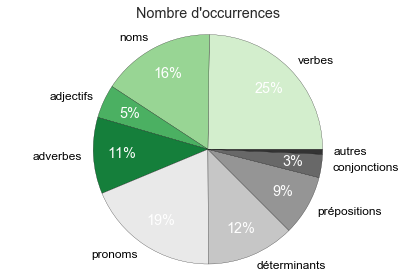

In [27]:
DFAX=pd.DataFrame(proportionsCgram,columns=["cat","prop"]).set_index("cat")
ax=DFAX.plot(kind="pie",y="prop",
             labels=DFAX.index,
             autopct=lambda p: '%1d%%'%round(p) if round(p) > 1 else '',
             pctdistance = 0.75, 
             textprops=dict(color="black",),
             colors=sns.color_palette("Greens", 4)+sns.color_palette("Greys", 5),
            )
for text in ax.texts:
    if "%" in text.get_text():
        text.set_color('white')
ax.set_title(u"Nombre d'occurrences",y=1.05)
ax.axis('equal')
ax.set(ylabel="")
ax.get_legend().remove()
#ax.legend(labels=DFAX.index,
#          title=u"Catégories",
#          loc="center right",
#          bbox_to_anchor=(.75, 0, 0.5, 1))
plt.tight_layout()
plt.savefig(repHDR+u'Lex3-FrequenceCategorie.png', dpi=300, bbox_inches="tight")
plt.show()

#### Ajout du rang pour les formes

In [28]:
lex3.loc[lex3["9_freqfilms2"]>0,"rangFW"]=lex3.loc[lex3["9_freqfilms2"]>0,"9_freqfilms2"].rank(ascending=False)
lex3.loc[lex3["10_freqlivres"]>0,"rangTW"]=lex3.loc[lex3["10_freqlivres"]>0,"10_freqlivres"].rank(ascending=False)
lex3[(lex3["4_cgram"].isin(catNonLex))&(lex3["9_freqfilms2"]>0)].sort_values("rangFW",ascending=True)

,1_ortho,2_phon,3_lemme,4_cgram,5_genre,6_nombre,7_freqlemfilms2,8_freqlemlivres,9_freqfilms2,10_freqlivres,11_infover,rangFW,rangTW
74319,je,Z2,je,PRO:per,NaN,s,25983.20,10862.77,25983.20,10862.77,NaN,1.0,11.0
35278,de,d2,de,PRE,NaN,NaN,25220.86,38928.92,25220.86,38928.92,NaN,2.0,1.0
75471,la,la,la,ART:def,f,s,14946.48,23633.92,14946.48,23633.92,NaN,5.0,2.0
132592,tu,ty,tu,PRO:per,NaN,s,14661.76,2537.03,14661.76,2537.03,NaN,6.0,50.0
76448,le,l2,le,ART:def,m,s,13652.76,18310.95,13652.76,18310.95,NaN,7.0,5.0
136706,vous,vu,vous,PRO:per,NaN,p,13589.70,3507.16,13589.70,3507.16,NaN,8.0,39.0
68080,il,il,il,PRO:per,m,s,13222.93,15832.09,13222.93,15832.09,NaN,10.0,6.0
52787,et,e,et,CON,NaN,NaN,12909.08,20879.73,12909.08,20879.73,NaN,11.0,3.0
137701,à,a,à,PRE,NaN,NaN,12190.40,19209.05,12190.40,19209.05,NaN,12.0,4.0
133517,un,1,un,ART:ind,m,s,12087.62,13550.68,12087.62,13550.68,NaN,13.0,8.0


### Graphes Fréquence=f(Rang)

#### Distribution de la fréquence des formes dans Films

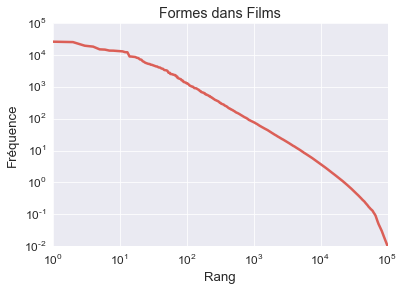

In [90]:
ax=lex3[lex3["9_freqfilms2"]>0].sort_values("rangFW").set_index("rangFW")["9_freqfilms2"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title="Formes dans Films")
None

#### Distribution de la fréquence des formes dans Textes

In [ ]:
ax=lex3[lex3["10_freqlivres"]>0].sort_values("rangTW").set_index("rangTW")["10_freqlivres"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title="Formes dans Textes")
None

#### Extraction des fréquences de lexèmes

In [483]:
lex3Lemmes=lex3.drop_duplicates(subset=["3_lemme","4_cgram","7_freqlemfilms2","8_freqlemlivres"]).copy()
lex3Lemmes.loc[lex3Lemmes["7_freqlemfilms2"]>0,"rangFL"]=lex3Lemmes.loc[lex3Lemmes["7_freqlemfilms2"]>0,"7_freqlemfilms2"].rank(ascending=False)
lex3Lemmes.loc[lex3Lemmes["8_freqlemlivres"]>0,"rangTL"]=lex3Lemmes.loc[lex3Lemmes["8_freqlemlivres"]>0,"8_freqlemlivres"].rank(ascending=False)
lex3Lemmes.sort_values("rangTL")

,1_ortho,2_phon,3_lemme,4_cgram,5_genre,6_nombre,7_freqlemfilms2,8_freqlemlivres,9_freqfilms2,10_freqlivres,11_infover,rangFW,rangTW,rangFL,rangTL
35278,de,d2,de,PRE,NaN,NaN,25220.86,38928.92,25220.86,38928.92,NaN,2.0,1.0,3.0,1.0
75471,la,la,la,ART:def,f,s,14946.48,23633.92,14946.48,23633.92,NaN,5.0,2.0,7.0,2.0
52787,et,e,et,CON,NaN,NaN,12909.08,20879.73,12909.08,20879.73,NaN,11.0,3.0,13.0,3.0
137701,à,a,à,PRE,NaN,NaN,12190.40,19209.05,12190.40,19209.05,NaN,12.0,4.0,14.0,4.0
76448,le,l2,le,ART:def,m,s,13652.76,18310.95,13652.76,18310.95,NaN,7.0,5.0,9.0,5.0
68080,il,il,il,PRO:per,m,s,13222.93,15832.09,13222.93,15832.09,NaN,10.0,6.0,12.0,6.0
52031,es,E,être,VER,NaN,NaN,32236.50,15085.47,1849.07,256.62,ind:pre:2s;,75.0,330.0,1.0,7.0
76505,les,le,les,ART:def,NaN,p,8720.38,14662.30,8720.38,14662.30,NaN,16.0,7.0,19.0,8.0
86465,n,En,ne,ADV,NaN,NaN,22287.83,13841.89,70.36,5.68,NaN,1085.5,10514.5,4.0,9.0
133517,un,1,un,ART:ind,m,s,12087.62,13550.68,12087.62,13550.68,NaN,13.0,8.0,15.0,10.0


In [484]:
nbLemmes=[]
for c in categories:
    nb=lex3Lemmes[(lex3Lemmes["7_freqlemfilms2"]>0) & (lex3Lemmes["4_cgram"].isin(cgrams[c]))]["4_cgram"].count()
    nbLemmes.append(nb)

In [485]:
nbLemmes

[5359, 24381, 9387, 1360, 161, 205, 71, 35, 206]

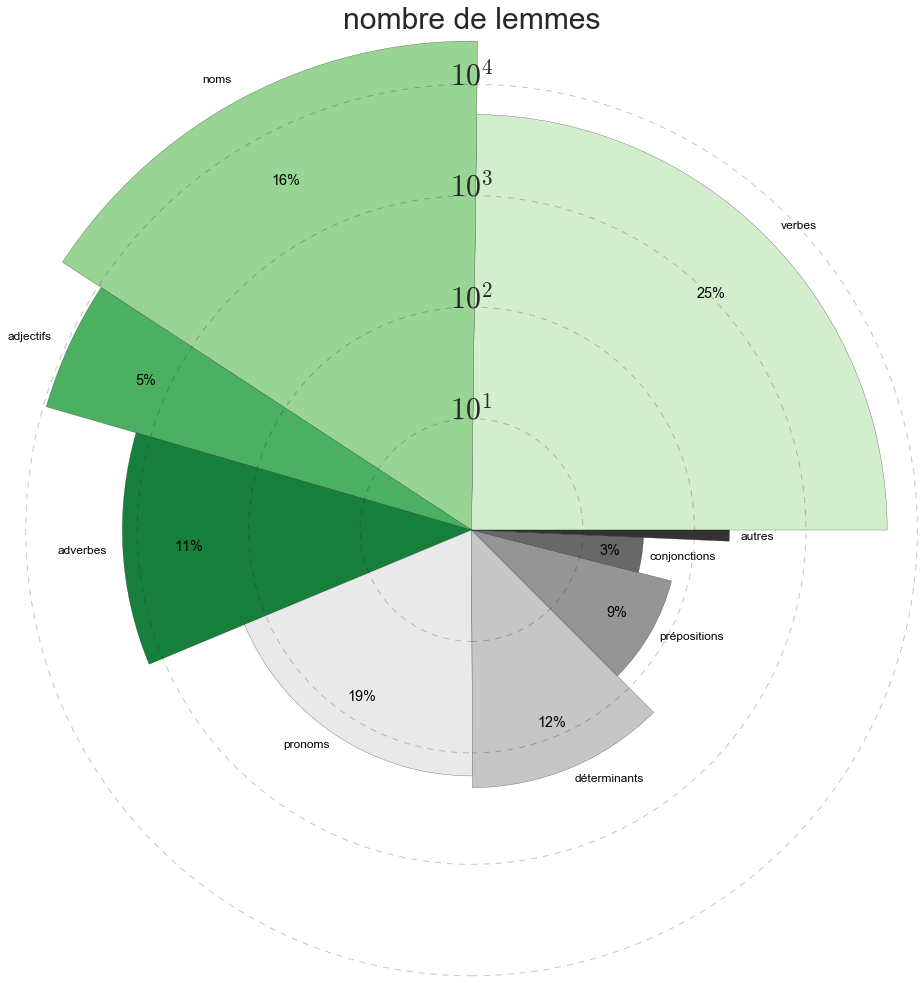

In [486]:
DFAX=pd.DataFrame(proportionsCgram,columns=["cat","prop"]).set_index("cat")
DFAX["nbLemmes"]=nbLemmes
props=DFAX["prop"].tolist()
#lemmes=[7000,12000,7000,3500,50,150,250,50,100]
heights=[]
for n,l in enumerate(nbLemmes):
    height=math.log(l,10)
    heights.append(height)
    
ax=DFAX.plot(kind="pie",y="prop",#figsize=(5,5),
             labels=DFAX.index,
#             labeldistance=5,
             autopct=lambda p: '%1d%%'%round(p) if round(p) > 1 else '',
             startangle=0,
#             pctdistance = np.mean(heights), 
             textprops=dict(color="black",),
             colors=sns.color_palette("Greens", 4)+sns.color_palette("Greys", 5),
            )
for n,wedge in enumerate(ax.patches):
    wedge.set_radius(heights[n])
nTexte=0
labAdjust=.95
pctAdjust=1.35
for text in ax.texts:
#    text.set_fontsize(32)
    if "%" not in text.get_text() and text.get_text()!="":
        x,y=text.get_position()
        text.set_position((x*heights[nTexte]*labAdjust,y*heights[nTexte]*labAdjust))
    elif text.get_text()!="":
        x,y=text.get_position()
        text.set_position((x*heights[nTexte]*pctAdjust,y*heights[nTexte]*pctAdjust))
        nTexte+=1
ax.get_legend().remove()
ax.axis('equal')
ax.annotate(r"$10^1$", xy=(0, 1), fontsize=30, ha="center",annotation_clip=False)
ax.annotate(r"$10^2$", xy=(0, 2), fontsize=30, ha="center",annotation_clip=False)
ax.annotate(r"$10^3$", xy=(0, 3), fontsize=30, ha="center",annotation_clip=False)
ax.annotate(r"$10^4$", xy=(0, 4), fontsize=30, ha="center",annotation_clip=False)
ax.annotate(u"nombre de lemmes", xy=(0, 4.5), fontsize=30, ha="center",annotation_clip=False)
#
# Attention :
#   Pour obtenir un cercle vide : fc="none", pas fc=None
#
circle1 = plt.Circle((0,0),1,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
circle2 = plt.Circle((0,0),2,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
circle3 = plt.Circle((0,0),3,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
circle4 = plt.Circle((0,0),4,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
fig = plt.gcf()
fig.gca().add_artist(circle1)
fig.gca().add_artist(circle2)
fig.gca().add_artist(circle3)
fig.gca().add_artist(circle4)
plt.savefig(repHDR+u'Lex3-Catégorie-FréquencePopulation.png', dpi=300, bbox_inches="tight")
plt.show()

In [487]:
DFAY=DFAX.copy()
DFAY=DFAY.append(DFAY.loc[['pronoms', u'déterminants',u'prépositions',u"conjonctions",u"autres"]].sum(), ignore_index=True).drop(DFAY.index.get_indexer(['pronoms', u'déterminants',u'prépositions',u"conjonctions",u"autres"]))
DFAY.index=u"verbes noms adjectifs adverbes grammèmes".split(" ")
DFAY

,prop,nbLemmes
verbes,0.248039,5359.0
noms,0.159714,24381.0
adjectifs,0.047332,9387.0
adverbes,0.107685,1360.0
grammèmes,0.437229,678.0


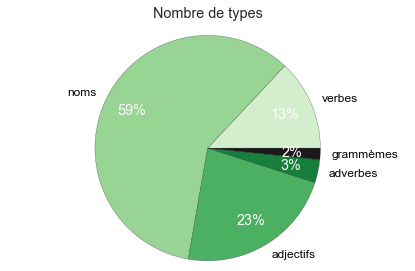

In [488]:
ax=DFAY.plot(kind="pie",y="nbLemmes",#figsize=(5,5),
             labels=DFAY.index,
#             labeldistance=5,
             autopct=lambda p: '%1d%%'%round(p) if round(p) > 1 else '',
             startangle=0,
             pctdistance = .75, 
             textprops=dict(color="black",),
             colors=sns.color_palette("Greens", 4)+["k"],
            )
for text in ax.texts:
    if "%" in text.get_text():
        text.set_color('w')
#        text.set_fontweight("heavy")
#        text.set_fontsize("large")
ax.set_title(u"Nombre de types",y=1.05)
ax.axis('equal')
ax.set(ylabel="")
ax.get_legend().remove()
plt.tight_layout()
plt.savefig(repHDR+u'Lex3-PopulationCategorie.png', dpi=300, bbox_inches="tight")
plt.show()

2.48038958521
1.59714031463
0.473315150248
1.07685152559
4.372290197


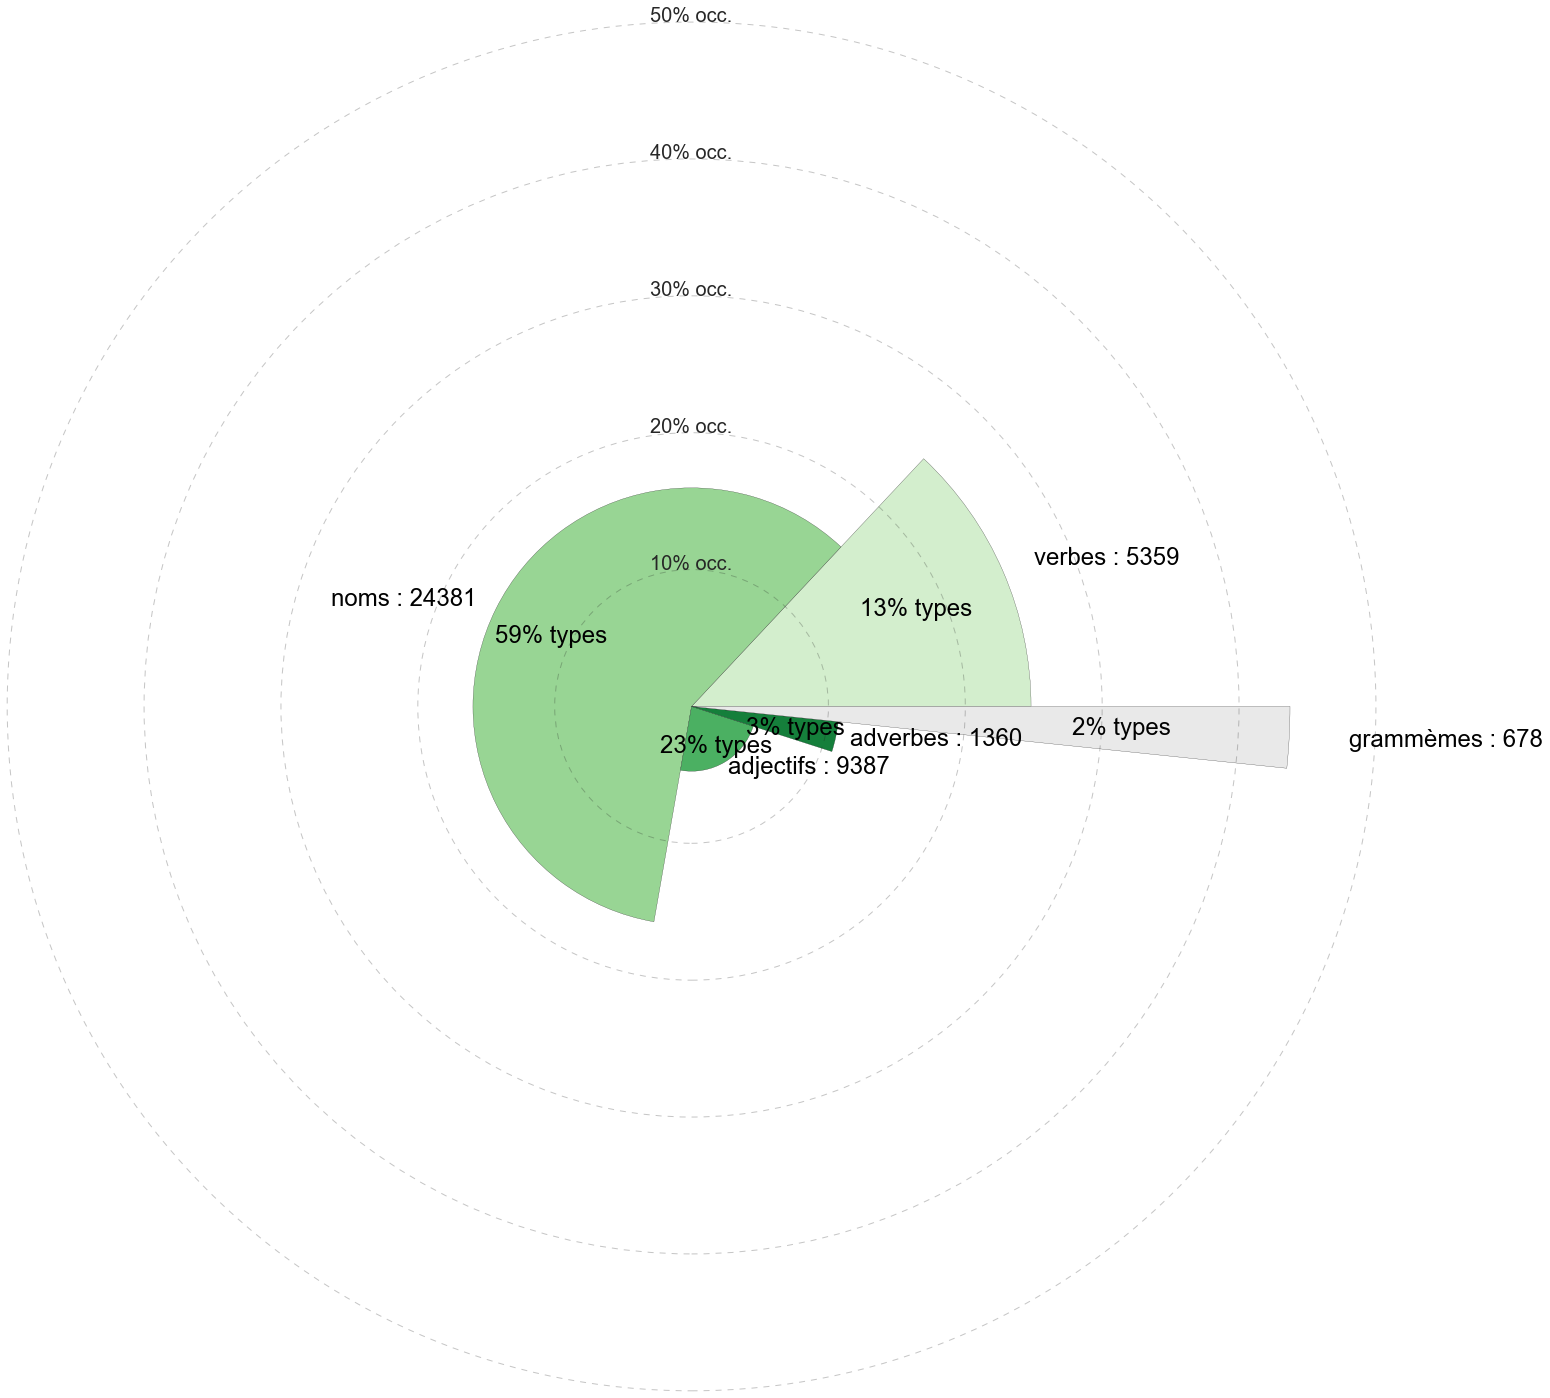

In [489]:
props=DFAY["prop"].tolist()
#lemmes=[7000,12000,7000,3500,50,150,250,50,100]
heights=[]
for n,p in enumerate(props):
    height=p*10
    print height
    heights.append(height)
    
ax=DFAY.plot(kind="pie",y="nbLemmes",figsize=(5,5),
             labels=['%s : %1d' % (l, s) for l, s in zip(DFAY.index, DFAY["nbLemmes"])],
#             labeldistance=5,
             autopct=lambda p: '%1d%% types'%round(p) if round(p) > 1 else '',
             startangle=0,
#             pctdistance = np.mean(heights), 
             textprops=dict(color="black",),
             colors=sns.color_palette("Greens", 4)+sns.color_palette("Greys", 5),
            )
for n,wedge in enumerate(ax.patches):
    wedge.set_radius(heights[n])
nTexte=0
labAdjust=1.
pctAdjust=1.2
for text in ax.texts:
    text.set_fontsize(24)
    if "%" not in text.get_text() and text.get_text()!="":
        x,y=text.get_position()
        text.set_position((x*heights[nTexte]*labAdjust,y*heights[nTexte]*labAdjust))
    elif text.get_text()!="":
        x,y=text.get_position()
        text.set_position((x*heights[nTexte]*pctAdjust,y*heights[nTexte]*pctAdjust))
        nTexte+=1
ax.get_legend().remove()
ax.axis('equal')
ax.annotate("10% occ.", xy=(0, 1), fontsize=20, ha="center",annotation_clip=False)
ax.annotate("20% occ.", xy=(0, 2), fontsize=20, ha="center",annotation_clip=False)
ax.annotate("30% occ.", xy=(0, 3), fontsize=20, ha="center",annotation_clip=False)
ax.annotate("40% occ.", xy=(0, 4), fontsize=20, ha="center",annotation_clip=False)
ax.annotate("50% occ.", xy=(0, 5), fontsize=20, ha="center",annotation_clip=False)
#ax.annotate(u"% occurrences", xy=(0, 5.5), fontsize=30, ha="center",annotation_clip=False)
#
# Attention :
#   Pour obtenir un cercle vide : fc="none", pas fc=None
#
circle1 = plt.Circle((0,0),1,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
circle2 = plt.Circle((0,0),2,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
circle3 = plt.Circle((0,0),3,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
circle4 = plt.Circle((0,0),4,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
circle5 = plt.Circle((0,0),5,color=None,fc="none", edgecolor='k',alpha=0.25,linewidth=1,clip_on=False,linestyle="--")
fig = plt.gcf()
fig.gca().add_artist(circle1)
fig.gca().add_artist(circle2)
fig.gca().add_artist(circle3)
fig.gca().add_artist(circle4)
fig.gca().add_artist(circle5)
plt.savefig(repHDR+u'Lex3-Categorie-PopulationFrequence.png', dpi=300, bbox_inches="tight")
plt.show()

#### Distribution de la fréquence des lexèmes dans Films

In [ ]:
ax=lex3Lemmes[lex3Lemmes["7_freqlemfilms2"]>0].sort_values("rangFL").set_index("rangFL")["7_freqlemfilms2"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Lemmes dans Films")
plt.show()
ax=lex3Lemmes[(lex3Lemmes["7_freqlemfilms2"]>0) &(lex3Lemmes["4_cgram"].isin(cgramLex))].sort_values("rangFL").set_index("rangFL")["7_freqlemfilms2"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Lexèmes dans Films")
plt.show()

#### Distribution de la fréquence des lexèmes dans Textes

In [ ]:
ax=lex3Lemmes[(lex3Lemmes["8_freqlemlivres"]>0)&(lex3Lemmes["4_cgram"].isin(cgramLex))].sort_values("rangTL").set_index("rangTL")["8_freqlemlivres"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Lexèmes dans Textes")
None

## Analyse de Verbes3

### Extraction des verbes de Lexique3

In [ ]:
lex3.rename(columns={'11_infover':'lex3_11_infover'}, inplace=True)

In [ ]:
verb3=lex3[lex3["4_cgram"].isin(["VER","AUX"])]

In [ ]:
verb3.loc[verb3["9_freqfilms2"]>0,"rangFWV"]=verb3.loc[verb3["9_freqfilms2"]>0,"9_freqfilms2"].rank(ascending=False)
verb3.loc[verb3["10_freqlivres"]>0,"rangTWV"]=verb3.loc[verb3["10_freqlivres"]>0,"10_freqlivres"].rank(ascending=False)
verb3.sort_values("rangTWV")

### Graphes Fréquence=f(Rang)

In [ ]:
ax=verb3[verb3["9_freqfilms2"]>0].sort_values("rangFWV").set_index("rangFWV")["9_freqfilms2"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title="Formes verbales dans Films")
None

In [ ]:
ax=verb3[verb3["10_freqlivres"]>0].sort_values("rangTWV").set_index("rangTWV")["10_freqlivres"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title="Formes verbales dans Textes")
None

#### Extraction des fréquences de lexèmes

In [ ]:
verb3Lemmes=verb3.drop_duplicates(subset=["3_lemme","4_cgram","7_freqlemfilms2","8_freqlemlivres"]).copy()
verb3Lemmes.loc[verb3Lemmes["7_freqlemfilms2"]>0,"rangFLV"]=verb3Lemmes.loc[verb3Lemmes["7_freqlemfilms2"]>0,"7_freqlemfilms2"].rank(ascending=False)
verb3Lemmes.loc[verb3Lemmes["8_freqlemlivres"]>0,"rangTLV"]=verb3Lemmes.loc[verb3Lemmes["8_freqlemlivres"]>0,"8_freqlemlivres"].rank(ascending=False)
verb3Lemmes.sort_values("rangTLV")

#### Distribution de la fréquence des lexèmes dans Films

In [ ]:
ax=verb3Lemmes[verb3Lemmes["7_freqlemfilms2"]>0].sort_values("rangFLV").set_index("rangFLV")["7_freqlemfilms2"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Lexèmes verbaux dans Films")
None

In [ ]:
ax=verb3Lemmes[verb3Lemmes["8_freqlemlivres"]>0].sort_values("rangTLV").set_index("rangTLV")["8_freqlemlivres"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Lexèmes verbaux dans Textes")
None

In [ ]:
pseudoZipfFilms=verb3Lemmes.sort_values("rangFLV").set_index("rangFLV")[["7_freqlemfilms2"]]
pseudoZipfLivres=verb3Lemmes.sort_values("rangTLV").set_index("rangTLV")[["8_freqlemlivres"]]

In [ ]:
pseudoZipfFilms=pseudoZipfFilms[pseudoZipfFilms["7_freqlemfilms2"]>0]
pseudoZipfFilms.drop_duplicates(inplace=True)
pseudoZipfFilms.reset_index(inplace=True)
pseudoZipfFilms

In [ ]:
pseudoZipfFilms["logFreq"]=pseudoZipfFilms["7_freqlemfilms2"].apply(math.log)
pseudoZipfFilms["logRank"]=pseudoZipfFilms["rangFLV"].apply(math.log)
coefs=[1.5,1.6,1.7,1.8,1.9]
for c in coefs:
    pseudoZipfFilms[c]=pseudoZipfFilms["logFreq"]+c*pseudoZipfFilms["logRank"]

In [ ]:
pseudoZipfFilms[coefs].plot()

# TESTS 
## Examen de la distribution des échantillons

In [ ]:
import pickle

In [ ]:
nomSample="/Volumes/gilles/Transfert/Copies-iMac-GB/2015-Data/Longitudinales/Longitudinal-55-T1100000-F41134.pkl"

In [ ]:
with open(nomSample,"rb") as input:
    dfSample=pickle.load(input)
dfSample["rang"]=dfSample.tir1.rank(ascending=False)

In [ ]:
ax=dfSample.sort_values("rang").set_index("rang")["tir1"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Formes verbales")
None

In [ ]:
lexemesSample=dfSample.groupby("lexeme")[["tir1"]].sum()
lexemesSample["rang"]=lexemesSample.tir1.rank(ascending=False)

In [ ]:
ax=lexemesSample.sort_values("rang").set_index("rang")["tir1"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Verbes")
None

# Projet de thèse Gauvain

In [ ]:
lex3[lex3["7_freqlemfilms2"]>=.1].groupby("3_lemme").count()

In [ ]:
for seuil in [100, 10, 1, 0.1, 0.01]:
    print "seuil",seuil
    dfFilms=lex3[lex3["7_freqlemfilms2"]>=seuil].groupby("3_lemme")
    countFilms=dfFilms.count()
    print "\tFilms"
#    print "\tTextes",lex3[(lex3["8_freqlemlivres"]>=seuil)].groupby("3_lemme").count().shape
#    print "\tLex3",lex3[(lex3["7_freqlemfilms2"]>=seuil)|(lex3["8_freqlemlivres"]>=seuil)].groupby("3_lemme").count().shape

In [ ]:
lex3.groupby("3_lemme").count()

In [ ]:
lex3[(lex3["7_freqlemfilms2"]>100)].groupby("3_lemme").count().shape[0]

In [ ]:
lex3[lex3["7_freqlemfilms2"]>=10].groupby("3_lemme").count().shape[0]

In [ ]:
lex3[lex3["7_freqlemfilms2"]>=1].groupby("3_lemme").count().shape[0]

In [ ]:
lex3[lex3["7_freqlemfilms2"]>=0.1].groupby("3_lemme").count().shape[0]

In [ ]:
lex3[lex3["7_freqlemfilms2"]>=0.01].groupby("3_lemme").count().shape[0]

In [ ]:
lex3[(lex3["8_freqlemlivres"]>100)].groupby("3_lemme").count().shape[0]

In [ ]:
lex3[(lex3["8_freqlemlivres"]>10)].groupby("3_lemme").count().shape[0]

In [ ]:
lex3[(lex3["8_freqlemlivres"]>1)].groupby("3_lemme").count().shape[0]

In [ ]:
lex3[(lex3["8_freqlemlivres"]>0.1)].groupby("3_lemme").count().shape[0]

In [ ]:
lex3[(lex3["8_freqlemlivres"]>0.01)].groupby("3_lemme").count().shape[0]

# Hart & Risley
Dans leur étude, Hart et Risley proposent que l'exposition des enfants varient d'un milieu social à un autre en terme de mots adressés à l'enfant entre 600 et 2000 mots par heure avec 5 heures de communication par jour.

Avec cet ordre de grandeur, on peut estimer une fourchette du nombre de tokens perçu au cours du temps :
 - fourchette basse : 150M de mots en 12 ans
 - fouchette haute : 520M de mots en 12 ans

In [399]:
def roundElement(x,nbRound=2):
    text="0"
    if nbRound==1:
        round1="%f"
        round2="%.1f"
    elif nbRound==2:
        round1="%.1f"
        round2="%.2f"        
    if x!=0:
        magnitude=int(np.log10(x))
        x=round(float(x)/(10**magnitude),nbRound)*10**magnitude
        if magnitude>9:
            unit="G"
            value=(round1%(float(x)/1e9)).strip("0").strip(".")
        elif magnitude==9:
            unit="G"
            value=(round2%(float(x)/1e9)).strip("0").strip(".")
        elif magnitude>6:
            unit="M"
            value=(round1%(float(x)/1e6)).strip("0").strip(".")
        elif magnitude==6:
            unit="M"
            value=(round2%(float(x)/1e6)).strip("0").strip(".")
        elif magnitude>3:
            unit="k"
            value=(round1%(float(x)/1e3)).strip("0").strip(".")
        elif magnitude==3:
            unit="k"
            value=(round2%(float(x)/1e3)).strip("0").strip(".")
        elif magnitude>0:
            unit=""
            value=(round1%float(x)).strip("0").strip(".")
        else:
            unit=""
            value=x
        text="%s%s"%(value,unit)
    return text


In [398]:
def roundTable(series,nbRound=2):
    result=series.copy()
    for ix,el in result.iteritems():
        result.loc[ix]=roundElement(el,nbRound)
    return result

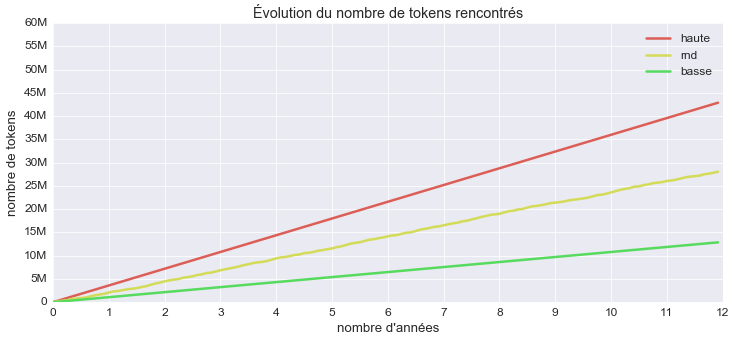

\begin{tabular}{lllllllllllll}
\toprule
{} &   11  &   23  &   35  &   47  &   59  &   71  &   83  &   95  &   107 &  119 &  131 &  143 \\
\midrule
haute &  3.3M &  6.9M &   11M &   14M &   18M &   21M &   25M &   29M &   32M &  36M &  39M &  43M \\
rnd   &  1.8M &  4.2M &  6.6M &  9.1M &   11M &   14M &   16M &   19M &   21M &  23M &  26M &  28M \\
basse &  990k &  2.1M &  3.1M &  4.2M &  5.3M &  6.4M &  7.5M &  8.6M &  9.6M &  11M &  12M &  13M \\
\bottomrule
\end{tabular}



In [405]:
estBasse=600
estHaute=2000
journee=5
periode=journee*30
nbPoints=12*12
serieBasse=[i*periode*estBasse for i in range(nbPoints)]
serieHaute=[i*periode*estHaute for i in range(nbPoints)]
#print serieBasse,serieHaute
serieRnd=[]
sumRnd=0
for i in range(nbPoints):
    serieRnd.append(sumRnd)
    rnd=np.random.rand()
    elementRnd=estBasse*periode*rnd+estHaute*periode*(1-rnd)
    sumRnd+=elementRnd
estimationsHR=pd.DataFrame(serieBasse,columns=["basse"])
estimationsHR["haute"]=serieHaute
estimationsHR["rnd"]=serieRnd
estimationsHR=estimationsHR[["haute","rnd","basse"]]
ax=estimationsHR.plot(kind="line",title=u"Nombre de tokens",figsize=(12,5))
ax.set(yscale="linear",
       xlabel=u"nombre d'années",ylabel=u"nombre de tokens",title=u"Évolution du nombre de tokens rencontrés"
      )

ax.xaxis.set_ticks(np.linspace(0,144,num=13))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(Mois2Annees))

ax.yaxis.set_ticks(np.linspace(0,60000000,num=13))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(reFormatTicks))
plt.show()

sampleAnnees=[(i+1)*12-1 for i in range(12)]
print estimationsHR.loc[sampleAnnees,:].apply(lambda x: roundTable(x,1)).T.to_latex()

# Tests de correspondances entre tokens et vocabulaire

Il faut faire le calcul au niveau des formes et des lemmes. Pour les lemmes, on peut faire une estimation du pourcentage d'une catégorie par tranche de facteur 10 et de même pour les formes :
- verbes :
 - formes : 
 - lemmes : .21,.27,.19,.13,.13
  - la queue de la distribution est problématique...
- noms :
 - formes : 
 - lemmes :
- adjectifs :
 - formes : 
 - lemmes :



In [136]:
def getCatSize(catDist,uniques):
    result=0
    for u in sorted(uniques):
        if u<=100:
            if np.random.rand()<=catDist[0]:
                result+=1
        elif u<=1000:
            if np.random.rand()<=catDist[1]:
                result+=1
        elif u<=10000:
            if np.random.rand()<=catDist[2]:
                result+=1
        elif u<=100000:
            if np.random.rand()<=catDist[3]:
                result+=1
        elif u<=1000000:
            if np.random.rand()<=catDist[4]:
                result+=1
    return result

In [138]:
def getZipfSizeTable(coefs,tokenNumbers,catDist=None):
    locCatZipfSizes={}
    locZipfSizes={}
    for coef in coefs:
        if coef not in locZipfSizes:
            locZipfSizes[coef]={}
            locCatZipfSizes[coef]={}
        for nbTokens in tokenNumbers:
            zipf=np.random.zipf(coef,nbTokens)
            uniques=np.unique(zipf)
            zipfSize=len(uniques)
            locZipfSizes[coef][nbTokens]=zipfSize
            if catDist:
                catSize=getCatSize(catDist,uniques)
                locCatZipfSizes[coef][nbTokens]=catSize
            else:
                catSize=1
            print coef,math.log(nbTokens,10),math.log(zipfSize,10), math.log(catSize,10)
            print datetime.now().strftime('%H:%M:%S') 
    return locZipfSizes,locCatZipfSizes

In [ ]:
testTirages=int("10 000 000 000")
testCoef=1.2
testZipf=np.random.zipf(testCoef,testTirages)

In [ ]:
uniques,counts=np.unique(testZipf,return_counts=True)

In [ ]:
testTypes=0
testTokens=0
catDist=catDistMots["verbes"]
for nU,u in enumerate(uniques):
    if u<=100:
        if np.random.rand()<=catDist[100]/100.:
            testTypes+=1
            testTokens+=counts[nU]
    elif u<=1000:
        if np.random.rand()<=catDist[1000]/1000.:
            testTypes+=1
            testTokens+=counts[nU]
    elif u<=10000:
        if np.random.rand()<=catDist[10000]/10000.:
            testTypes+=1
            testTokens+=counts[nU]
    elif u<=100000:
        if np.random.rand()<=catDist[100000]/100000.:
            testTypes+=1
            testTokens+=counts[nU]
    elif u<=1000000:
        if np.random.rand()<=catDist[1000000]/1000000.:
            testTypes+=1
            testTokens+=counts[nU]
testTypes,testTokens, float(testTokens)/testTirages

In [ ]:
float(testTokens)/1000000000

In [ ]:
coefs=[1+(i+1)/100. for i in range(20)]
tokenNumbers=[int(1E5*(i+1)) for i in range(9)]+[int(1E6*(i+1)) for i in range(9)]+[int(1E7*(i+1)) for i in range(9)]+[int(1E8*(i+1)) for i in range(5)]

In [491]:
catDistMots={}
catDistLemmes={}
for c in categories:
    print c
    catDistMots[c]={}
    catDistLemmes[c]={}
    sPrevMots=0
    sPrevLemmes=0
    for i in range(1,7):
        sNowMots=lex3[(lex3["4_cgram"].isin(cgrams[c]))&(lex3["9_freqfilms2"]>0)&(lex3["rangFW"]<=10**(i+1))].count()["1_ortho"]
        print "W",10**(i+1),sNowMots-sPrevMots,(sNowMots-sPrevMots)/10.**(i+1)*100
        catDistMots[c][10**(i+1)]=(sNowMots-sPrevMots)#/10.**(i+1)*100
        sPrevMots=sNowMots
        sNowLemmes=lex3Lemmes[(lex3Lemmes["4_cgram"].isin(cgrams[c]))&(lex3Lemmes["7_freqlemfilms2"]>0)&(lex3Lemmes["rangFL"]<=10**(i+1))].count()["1_ortho"]
        print "L",10**(i+1),sNowLemmes-sPrevLemmes,(sNowLemmes-sPrevLemmes)/10.**(i+1)*100
        catDistLemmes[c][10**(i+1)]=(sNowLemmes-sPrevLemmes)#/10.**(i+1)*100
        sPrevLemmes=sNowLemmes        

verbes
W 100 24 24.0
L 100 21 21.0
W 1000 343 34.3
L 1000 245 24.5
W 10000 3342 33.42
L 10000 1660 16.6
W 100000 36515 36.515
L 100000 3433 3.433
W 1000000 8146 0.8146
L 1000000 0 0.0
W 10000000 0 0.0
L 10000000 0 0.0
noms
W 100 1 1.0
L 100 1 1.0
W 1000 306 30.6
L 1000 390 39.0
W 10000 4126 41.26
L 10000 5223 52.23
W 100000 27832 27.832
L 100000 18766 18.766
W 1000000 5174 0.5174
L 1000000 0 0.0
W 10000000 0 0.0
L 10000000 0 0.0
adjectifs
W 100 1 1.0
L 100 3 3.0
W 1000 85 8.5
L 1000 92 9.2
W 10000 1168 11.68
L 10000 1641 16.41
W 100000 16228 16.228
L 100000 7651 7.651
W 1000000 3459 0.3459
L 1000000 0 0.0
W 10000000 0 0.0
L 10000000 0 0.0
adverbes
W 100 15 15.0
L 100 13 13.0
W 1000 66 6.6
L 1000 70 7.0
W 10000 173 1.73
L 10000 254 2.54
W 100000 922 0.922
L 100000 1023 1.023
W 1000000 190 0.019
L 1000000 0 0.0
W 10000000 0 0.0
L 10000000 0 0.0
pronoms
W 100 27 27.0
L 100 30 30.0
W 1000 28 2.8
L 1000 29 2.9
W 10000 70 0.7
L 10000 83 0.83
W 100000 32 0.032
L 100000 19 0.019
W 1000000 4 0.

In [492]:
dfCatDistMots=pd.DataFrame.from_dict(catDistMots)[categories].T
dfCatDistMots=dfCatDistMots.append(dfCatDistMots.loc[['pronoms', u'déterminants',u'prépositions',u"conjonctions",u"autres"]].sum(), ignore_index=True).drop(dfCatDistMots.index.get_indexer(['pronoms', u'déterminants',u'prépositions',u"conjonctions",u"autres"]))
dfCatDistMots.index=u"verbes noms adjectifs adverbes grammèmes".split(" ")
dfCatDistMots.drop([10000000],axis=1,inplace=True)
print dfCatDistMots.T.sum().to_latex()

\begin{tabular}{lr}
\toprule
{} &      0 \\
\midrule
verbes    &  48370 \\
noms      &  37439 \\
adjectifs &  20941 \\
adverbes  &   1366 \\
grammèmes &    678 \\
\bottomrule
\end{tabular}



In [ ]:
for trancheRang in dfCatDistMots.columns.tolist():
    ax=dfCatDistMots[dfCatDistMots[trancheRang]>0].plot(kind="pie",y=trancheRang,#figsize=(5,5),
                 autopct=lambda p: '%1d%%'%round(p) if round(p) > 1 else '',
                 pctdistance = 0.75, 
                 textprops=dict(color="black",),
                 colors=sns.color_palette("Greens", 4)+sns.color_palette("Greys", 5),
                      )

    for text in ax.texts:
        if "%" in text.get_text():
            text.set_color('k')
    #ax.set_title(u"Nombre d'occurrences",y=1.05)
    ax.axis('equal')
    ax.set(ylabel="")
    ax.get_legend().remove()
    #ax.legend(labels=DFAX.index,
    #          title=u"Catégories",
    #          loc="center right",
    #          bbox_to_anchor=(.75, 0, 0.5, 1))
    plt.tight_layout()
    plt.savefig(repHDR+u'Lex3-FrequenceCategorie-Mots-%d.png'%trancheRang, dpi=300, bbox_inches="tight")
    plt.show()

In [493]:
dfCatDistLemmes=pd.DataFrame.from_dict(catDistLemmes)[categories].T
dfCatDistLemmes=dfCatDistLemmes.append(dfCatDistLemmes.loc[['pronoms', u'déterminants',u'prépositions',u"conjonctions",u"autres"]].sum(), ignore_index=True).drop(dfCatDistLemmes.index.get_indexer(['pronoms', u'déterminants',u'prépositions',u"conjonctions",u"autres"]))
dfCatDistLemmes.index=u"verbes noms adjectifs adverbes grammèmes".split(" ")
dfCatDistLemmes.drop([1000000,10000000],axis=1,inplace=True)
print dfCatDistLemmes.T.sum().to_latex()

\begin{tabular}{lr}
\toprule
{} &      0 \\
\midrule
verbes    &   5359 \\
noms      &  24380 \\
adjectifs &   9387 \\
adverbes  &   1360 \\
grammèmes &    678 \\
\bottomrule
\end{tabular}



In [501]:
lex3Paradigmes=pd.DataFrame([dfCatDistLemmes.T.sum(),dfCatDistMots.T.sum()]).T
lex3Paradigmes.columns=u"lemmes formes".split(" ")
lex3Paradigmes["P1"]=[51,2,4,0,0]
lex3Paradigmes=lex3Paradigmes.T[u"verbes noms adjectifs".split(" ")].T
lex3Paradigmes["P2"]=lex3Paradigmes["lemmes"]*lex3Paradigmes["P1"]
lex3Paradigmes["remplissage"]=lex3Paradigmes["formes"]/lex3Paradigmes["P2"].astype(float)*100

In [520]:
print lex3Paradigmes.apply(lambda x: roundTable(x,2)).to_latex(decimal=",",float_format="%.1f%%")
print lex3Paradigmes.to_latex(decimal=",",float_format="%.1f%%")

\begin{tabular}{llllll}
\toprule
{} & lemmes & formes &   P1 &     P2 & remplissage \\
\midrule
verbes    &  5.36k &  48.4k &   51 &   273k &        17.7 \\
noms      &  24.4k &  37.4k &  2.0 &  48.8k &        76.8 \\
adjectifs &  9.39k &  20.9k &  4.0 &  37.5k &        55.8 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrr}
\toprule
{} &  lemmes &  formes &  P1 &      P2 &  remplissage \\
\midrule
verbes    &    5359 &   48370 &  51 &  273309 &        17,7\% \\
noms      &   24380 &   37439 &   2 &   48760 &        76,8\% \\
adjectifs &    9387 &   20941 &   4 &   37548 &        55,8\% \\
\bottomrule
\end{tabular}



In [ ]:
for trancheRang in dfCatDistLemmes.columns.tolist():
    ax=dfCatDistLemmes[dfCatDistLemmes[trancheRang]>0].plot(kind="pie",y=trancheRang,#figsize=(5,5),
                 autopct=lambda p: '%1d%%'%round(p) if round(p) > 1 else '',
                 pctdistance = 0.75, 
                 textprops=dict(color="black",),
                 colors=sns.color_palette("Greens", 4)+sns.color_palette("Greys", 5),
                      )

    for text in ax.texts:
        if "%" in text.get_text():
            text.set_color('k')
    #ax.set_title(u"Nombre d'occurrences",y=1.05)
    ax.axis('equal')
    ax.set(ylabel="")
    ax.get_legend().remove()
    #ax.legend(labels=DFAX.index,
    #          title=u"Catégories",
    #          loc="center right",
    #          bbox_to_anchor=(.75, 0, 0.5, 1))
    plt.tight_layout()
    plt.savefig(repHDR+u'Lex3-FrequenceCategorie-Lemmes-%d.png'%trancheRang, dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:
lex3Lemmes[(lex3Lemmes["4_cgram"].isin(cgramV))&(lex3Lemmes["7_freqlemfilms2"]>0)&(lex3Lemmes["rangFL"]<=100000)].count()

In [352]:
vCatDistLemmes=[.21,.27,.19,.03,.001]
vCatDistMots=[.24,.367,.37,.402,.048]

In [372]:
#coefs=[1.25,1.53,1.89,2.09]
coefs=[1.15,1.32,1.86,4.29]
tokenNumbers=[int(1E3*(i+1)) for i in range(9)]+[int(1E4*(i+1)) for i in range(9)]+[int(1E5*(i+1)) for i in range(9)]+[int(1E6*(i+1)) for i in range(9)]+[int(1E7*(i+1)) for i in range(9)]+[int(1E8*(i+1)) for i in range(5)]
dictZipfSize,dictCatZipfSizeMots=getZipfSizeTable(coefs,tokenNumbers,catDist=vCatDistMots)

1.15 3.0 2.73399928654 2.1105897103
18:42:06
1.15 3.30102999566 2.97909290064 2.38201704257
18:42:06
1.15 3.47712125472 3.12319807503 2.46834733041
18:42:06
1.15 3.60205999133 3.21563756344 2.59106460703
18:42:06
1.15 3.69897000434 3.33805787542 2.71600334363
18:42:06
1.15 3.77815125038 3.39863432454 2.74585519517
18:42:06
1.15 3.84509804001 3.44622640178 2.80550085816
18:42:06
1.15 3.90308998699 3.49734438102 2.8543060418
18:42:06
1.15 3.95424250944 3.54838941813 2.88761730034
18:42:06
1.15 4.0 3.59538598081 2.9253120915
18:42:06
1.15 4.30102999566 3.84701709794 3.16583762469
18:42:06
1.15 4.47712125472 4.00069431587 3.3018977172
18:42:06
1.15 4.60205999133 4.1091396439 3.40397796367
18:42:06
1.15 4.69897000434 4.19942604159 3.48230176722
18:42:06
1.15 4.77815125038 4.26399093268 3.52917360326
18:42:06
1.15 4.84509804001 4.32064471136 3.58126680527
18:42:06
1.15 4.90308998699 4.37141885211 3.63124078024
18:42:06
1.15 4.95424250944 4.41345065101 3.66209644542
18:42:06
1.15 5.0 4.457094

ValueError: math domain error

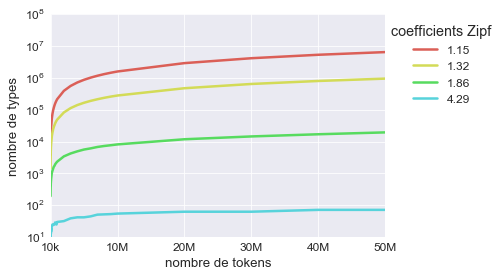

In [477]:
#samples=[1.8,1.9,2.0,2.1,2.2]
#samples=[1+(i+1)/100. for i in range(5)]
samples=[1.15,1.32,1.86,4.29]
dfZipfSizes=pd.DataFrame.from_dict(dictZipfSize)
ax=dfZipfSizes.iloc[:32][samples].plot(figsize=(6,4),)
ax.set(yscale="log",
       xlabel=u"nombre de tokens",ylabel=u"nombre de types",
      )
ax.xaxis.set_ticks(np.linspace(10000,50000000,num=6))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(reFormatTicks))
ax.yaxis.set_ticks(np.logspace(1,8,num=8))
#ax.yaxis.set_major_formatter(ticker.FuncFormatter(reFormatTicks))
plt.legend(bbox_to_anchor=(1.35, 1),title="coefficients Zipf")
plt.savefig(repHDR+u'Zipf-CoefTokens-Types.png', dpi=300, bbox_inches="tight")
plt.show()

In [425]:
np.logspace(1,9,num=9)

array([  1.00000000e+01,   1.00000000e+02,   1.00000000e+03,
         1.00000000e+04,   1.00000000e+05,   1.00000000e+06,
         1.00000000e+07,   1.00000000e+08,   1.00000000e+09])

In [173]:
display(dfZipfSizes.iloc[:5,:2])
display(dfZipfSizes.iloc[5:10,1:3])
display(dfZipfSizes.iloc[10:,2:4])

,1.25,1.53
100000,13555,2547
200000,23463,4086
300000,32710,5323
400000,41319,6425
500000,48675,7442


,1.53,1.89
600000,8385,1596
700000,9309,1762
800000,10191,1869
900000,10944,2000
1000000,11746,2069


,1.89,2.09
2000000,2992,1446
3000000,3756,1765
4000000,4330,1983
5000000,4856,2162
6000000,5417,2384
7000000,5805,2631
8000000,6249,2768
9000000,6724,2887
10000000,7203,3104
20000000,10125,4326


In [360]:
latexZipfSizes=dfZipfSizes.iloc[:,:].apply(roundTable)
latexZipfSizes.index=roundTable(pd.Series(latexZipfSizes.index))
print latexZipfSizes.to_latex()

\begin{tabular}{lllll}
\toprule
{} &   1.15 &   1.32 &   1.86 & 4.29 \\
\midrule
10k  &  3.85k &  1.44k &    194 &   11 \\
20k  &  7.07k &  2.49k &    278 &   10 \\
30k  &  10.1k &  3.49k &    375 &   12 \\
40k  &  12.8k &   4.2k &    395 &   15 \\
50k  &  15.5k &  5.08k &    489 &   15 \\
60k  &  18.5k &  5.67k &    515 &   13 \\
70k  &  21.2k &  6.54k &    562 &   14 \\
80k  &  23.4k &  7.15k &    593 &   19 \\
90k  &  26.2k &  7.76k &    634 &   15 \\
100k &  28.6k &  8.42k &    675 &   17 \\
200k &  52.1k &  14.5k &  1.03k &   22 \\
300k &  74.8k &  19.4k &  1.23k &   25 \\
400k &  95.7k &  24.3k &  1.42k &   24 \\
500k &   116k &  28.9k &  1.64k &   25 \\
600k &   136k &  32.7k &  1.74k &   25 \\
700k &   156k &  37.2k &  1.93k &   29 \\
800k &   175k &  41.2k &  2.07k &   28 \\
900k &   194k &  44.9k &   2.2k &   25 \\
1M   &   213k &  48.6k &  2.33k &   30 \\
2M   &   389k &  81.7k &  3.42k &   32 \\
3M   &   554k &   112k &  4.22k &   39 \\
4M   &   711k &   139k &  4.92k &   4

# Approximation de la distribution par morceaux
La distribution des fréquences dans Lexique3 ne correspond pas à une zipf uniforme. Pour approcher de cette distribution, on coupe la distribution en morceaux et on cherche la zipf la plus proche pour chaque morceau.

Le calcul des coefficients est fait par régression linéaire sur la correspondance entre le log du rang et le log de la fréquence pour chaque plage. Les coefficients varie de 1.25 pour la tête de la distribution à 2.09 pour la queue.

In [359]:
lex3["rangFW"].max()

100307.0

8.05451194837
[-1.89106979]
('Mean Absolute Error:', 0.16910618052647336)
('Mean Squared Error:', 0.043227408453840731)
('Root Mean Squared Error:', 0.20791202094597785)


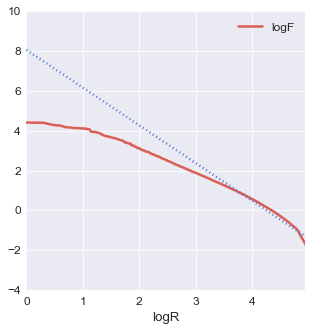

In [339]:
testRangMin=0
testRangMax=100000
testDF=lex3[(lex3["rangFW"]>=testRangMin)&(lex3["rangFW"]<testRangMax)].sort_values("rangFW").set_index("rangFW")[["9_freqfilms2"]].reset_index()
testDF["logR"]=np.log10(testDF["rangFW"])
testDF["logF"]=np.log10(testDF["9_freqfilms2"])
testDF=testDF[["logR","logF"]]
testDF[["logR","logF"]].describe()

X = testDF.iloc[:, :-1].values  
y = testDF.iloc[:, 1].values  

from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  
X_train,y_train

from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
print(regressor.intercept_)  
print(regressor.coef_)  


ax=testDF.plot(x="logR",y="logF",figsize=(5,5))
x = np.linspace(0,np.log10(testRangLimite),100)
y = regressor.coef_*x+regressor.intercept_
plt.plot(x, y, ':b', label='y=2x+1')

y_pred = regressor.predict(X_test)

from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  



In [367]:
dfZipfSizes["cumul"]=0

In [233]:
def cumulerZipf(df,ix1,ix2,c1,c2,ajoutCumul=0):
    if ix1==0:
        lAjout=0
        lIntervalle=(df.index>=ix1)&(df.index<ix2)
        df.loc[lIntervalle,"cumul"]=df.loc[lIntervalle,c2]
#        display(df)
    else:
        lAjout=df[df.index==ix1][c1].values[0]-df[df.index==ix1][c2].values[0]
        ajoutCumul+=lAjout
        lIntervalle=(df.index>=ix1)&(df.index<ix2)
        df.loc[lIntervalle,"cumul"]=df.loc[lIntervalle,c2]+ajoutCumul
#        display(df)
    return ajoutCumul

# cumul500=dfZipfSizes[dfZipfSizes.index==500000][1.25].values[0]-dfZipfSizes[dfZipfSizes.index==500000][1.53].values[0]
# dfZipfSizes.loc[(dfZipfSizes.index>=500000)&(dfZipfSizes.index<1000000),"cumul"]=dfZipfSizes.loc[(dfZipfSizes.index>=500000)&(dfZipfSizes.index<1000000),1.53]+cumul500
# cumul1000=dfZipfSizes[dfZipfSizes.index==1000000][1.53].values[0]-dfZipfSizes[dfZipfSizes.index==1000000][1.89].values[0]+cumul500
# dfZipfSizes.loc[(dfZipfSizes.index>=1000000)&(dfZipfSizes.index<10000000),"cumul"]=dfZipfSizes.loc[(dfZipfSizes.index>=1000000)&(dfZipfSizes.index<10000000),1.89]+cumul1000
# cumul10000=dfZipfSizes[dfZipfSizes.index==1000000][1.53].values[0]-dfZipfSizes[dfZipfSizes.index==1000000][1.89].values[0]+cumul1000
# dfZipfSizes.loc[(dfZipfSizes.index>=1000000)&(dfZipfSizes.index<10000000),"cumul"]=dfZipfSizes.loc[(dfZipfSizes.index>=1000000)&(dfZipfSizes.index<10000000),1.89]+cumul10000
# cumul100000=dfZipfSizes[dfZipfSizes.index==10000000][1.89].values[0]-dfZipfSizes[dfZipfSizes.index==10000000][2.09].values[0]+cumul10000
# dfZipfSizes.loc[(dfZipfSizes.index>=10000000)&(dfZipfSizes.index<100000000),"cumul"]=dfZipfSizes.loc[(dfZipfSizes.index>=10000000)&(dfZipfSizes.index<100000000),2.09]+cumul100000


In [370]:
tranchesCoef=[(0,0),(1.15,30000),(1.32,1000000),(1.86,10000000),(4.29,100000000),(4.29,100000000)]
ajoutCumul=0
for i in range(len(tranchesCoef)-1):
    ajoutCumul=cumulerZipf(dfZipfSizes,tranchesCoef[i][1],tranchesCoef[i+1][1],tranchesCoef[i][0],tranchesCoef[i+1][0],ajoutCumul)
dfZipfSizes

,1.15,1.32,1.86,4.29,cumul
0,0.0,0.0,0.0,0.0,0.0
10000,3855.0,1440.0,194.0,11.0,3855.0
20000,7069.0,2490.0,278.0,10.0,7069.0
30000,10057.0,3490.0,375.0,12.0,10057.0
40000,12829.0,4196.0,395.0,15.0,10763.0
50000,15483.0,5075.0,489.0,15.0,11642.0
60000,18455.0,5668.0,515.0,13.0,12235.0
70000,21152.0,6543.0,562.0,14.0,13110.0
80000,23380.0,7151.0,593.0,19.0,13718.0
90000,26197.0,7756.0,634.0,15.0,14323.0


In [362]:
dfZipfSizes.loc[0,:]=0
dfZipfSizes.sort_index(inplace=True)
dfDiff=dfZipfSizes[[1.15,1.32,1.86,4.29]].diff()
dfDiff["cumul"]=dfZipfSizes["cumul"]
dfDiff.index=roundTable(pd.Series(dfDiff.index))
print dfDiff.iloc[1:].apply(roundTable).to_latex()

/Users/gilles/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


ValueError: ('cannot convert float NaN to integer', u'occurred at index 4.29')

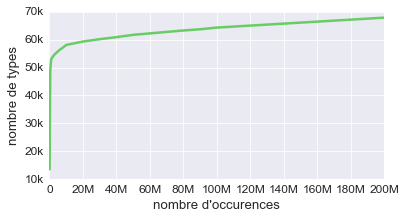

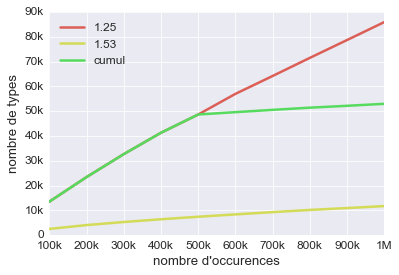

In [292]:
ax=dfZipfSizes.iloc[:-3]["cumul"].plot(figsize=(6,3),color="g")
ax.xaxis.set_ticks(np.linspace(0,200000000,num=11))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(reFormatTicks))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(reFormatTicks))
ax.set(xlabel="nombre d'occurences",ylabel="nombre de types")
plt.show()
ax=dfZipfSizes.iloc[:10][[1.25,1.53,"cumul"]].plot()
#ax.xaxis.set_ticks(np.linspace(0,200000000,num=11))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(reFormatTicks))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(reFormatTicks))
ax.set(xlabel="nombre d'occurences",ylabel="nombre de types")
plt.show()


In [241]:
samples=[1.8,1.9,2.0,2.1,2.2]
samples=[1+(4*i+1)/100. for i in range(5)]
samples=[1.25,1.53,1.89,2.09]
dfCatZipfSizes=pd.DataFrame.from_dict(dictCatZipfSizeMots)
ax=dfCatZipfSizes[samples].plot(figsize=(8,4))
#ax.set(yscale="log")
ax.xaxis.set_ticks(np.linspace(0,500000000,num=11))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(reFormatTicks))
plt.savefig(repHDR+u'Zipf-CoefTokens-Verbes.png', dpi=300, bbox_inches="tight")
plt.show()



TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
roundElement(1453.756468)

In [ ]:
print dfZipfSizes.loc[100000000:,samples].apply(roundTable).to_latex()

In [ ]:
print dfCatZipfSizes.loc[100000000:,samples].apply(roundTable).to_latex()

In [ ]:
dfZipfSizes.to_csv(path_or_buf="ZipfCoefTokensTypes.csv",sep="\t",encoding="utf8")
dfCatZipfSizes.to_csv(path_or_buf="ZipfCoefTokensTypes-Verbes.csv",sep="\t",encoding="utf8")

In [ ]:
testTokens=1000
test=np.random.zipf(1.3,testTokens)
len(test[test>1000000])/float(testTokens)